In [1]:
from utils.plotting import RewardHistory
from utils.epsilon import Epsilon
from utils.replay_memory import Transition, ReplayMemory

import numpy as np
import gym as gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
from IPython import display
import cv2 as cv2
import random
# %matplotlib inline
# matplotlib.get_backend()
# plt.isinteractive()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T


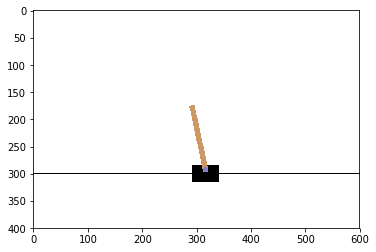

In [2]:
env = gym.make("CartPole-v0")
env.reset()

for i in range(100):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    if done:
        break
        
display.clear_output(wait=True)

env.close()

In [3]:
def process_screen(image):
    img = image[150:330, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

env = gym.make("CartPole-v0")
env.reset()
prev_screen = process_screen(env.render(mode='rgb_array'))

for i in range(1):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    screen = process_screen(screen)
    print(screen.shape)
    plt.imshow(screen, cmap="gray")
    
    if done:
        break
        
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(180, 600)


In [66]:
class DQNLinear(nn.Module):
    def __init__(self, *args):
        super(DQNLinear, self).__init__(*args)
        self.fc1 = nn.Linear(4, 128)
#         self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

dqn = DQNLinear()
print(dqn)

# x = np.stack([screen, prev_screen], axis=2)
# x = np.expand_dims(x, axis=0)
# x = np.rollaxis(x, 3, 1)
x = torch.Tensor([1, 1, 1, 1])
x = torch.unsqueeze(x, 0)
x = Variable(x).float()
print(x.data.numpy().shape)
# print(x)
# x = Variable(torch.randn(2, 2, 180, 600))
        
output = dqn(x)
print(output.data.numpy().shape)

# create your optimizer
optimizer = optim.Adam(dqn.parameters(), lr=0.01)
criterion = nn.MSELoss()

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = dqn(x)
loss = criterion(output, Variable(torch.Tensor([[0,0]])))
loss.backward()
optimizer.step()    # Does the update

DQNLinear(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
(1, 4)
(1, 2)


# Ok, now we do DQN with the continuous states received rather than pixels

In [67]:
import copy
class DQNLinearLearner(object):
    def __init__(self, env=None, double_Q=False):
        self.env = gym.make("CartPole-v0")
        self.epsilon = Epsilon(start=1.0, end=0.01, update_increment=0.015)
        self.gamma = 0.99
        self.train_q_per_step = 4
        self.train_q_batch_size = 256
        self.steps_before_training = 500
        self.target_q_update_frequency = 100
        
        self.memory = ReplayMemory(capacity=10000)
        self.Q = DQNLinear()
        self.Qt = DQNLinear()
        self.Qt.load_state_dict(self.Q.state_dict())
        for param in self.Qt.parameters():
            param.requires_grad = False
        self.use_double_Q = double_Q
        self.optimizer = optim.Adam(self.Q.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()

        self.reset()
        self.episode_rewards = []
        self.epsilon_log = []
        self.l_tq_squared_error = deque(maxlen=1000)
        

    def get_action(self, s):
        s = self.state_to_tensor(s)
        actions = self.Q(s)
        if np.random.rand() > self.epsilon.value():
            action = np.argmax(actions.data.numpy())
        else:
            action = self.env.action_space.sample()
        return action

    def state_to_tensor(self, s):
        x = torch.Tensor(s)
        x = torch.unsqueeze(x, 0)
        x = Variable(x).float()
        return x
    
    def reset(self):
        self.s = self.env.reset()
    
    def train(self, nb_episodes=1, display=None):
        self.epsilon.isTraining = True
        step = 0
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_action(self.s)
                s_1, r, done, _ = self.env.step(action)
                    
                transition = Transition(self.s, action, s_1, r, done)
                self.memory.push(transition)
                episode_reward += r
                step += 1
                self.s = s_1
                
                if done:
                    break;
                
                if step % self.train_q_per_step == 0 and step > self.steps_before_training:
                    self.train_q()
                    
                if step % self.target_q_update_frequency == 0 and step > self.steps_before_training:
                    self.update_target_q()
                    
                if display is not None and step % 100 == 0:
                    display(self)
                    
            if step > self.steps_before_training:
                self.epsilon.increment() # increment epsilon per episode
#             print("Episode reward: ", episode_reward)
            self.episode_rewards.append(episode_reward)
            self.epsilon_log.append(self.epsilon.value())

        if display is not None:
            display(self)
    
    def train_q(self):
#         print("training q. Memory size:", len(self.memory))
        if self.train_q_batch_size >= len(self.memory):
            return
        
        s, a, s_1, r, done = self.memory.sample(self.train_q_batch_size)
        s = Variable(torch.from_numpy(s)).float()
        a = Variable(torch.from_numpy(a)).long()
        s_1 = Variable(torch.from_numpy(s_1)).float()
        r = Variable(torch.from_numpy(r)).float()
        done = Variable(torch.from_numpy(1 - done)).float()
        
        # Q_sa = r + gamma * max(Q_s'a')
        Q = self.Q(s)
#         print("s:", s, "Q:", Q)
        Q = Q.gather(1, a)
#         print("a:", a, "Q:", Q)
        Qt = self.Qt(s_1)
#         print("s_1:", s_1, "Qt:", Qt)

        if self.use_double_Q:
            best_action = self.Q(s_1).max(dim=1)[1].view(-1, 1)
            y = r + done * self.gamma * Qt.gather(1, best_action)
        else:
            y = r + done * self.gamma * Qt.max(dim=1)[0].unsqueeze(1)

        loss = self.criterion(Q, y)
#         loss = F.smooth_l1_loss(Q, y)
        self.l_tq_squared_error.append(loss.data.numpy().sum())
        self.optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
#         for param in self.Q.parameters():
#             param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_q(self):
        """Update the target Q-value function by copying the current Q-value function weights."""
        self.Qt.load_state_dict(self.Q.state_dict())
        for param in self.Qt.parameters():
            param.requires_grad = False

    def run(self):
        self.env = gym.make("CartPole-v0")
        self.reset()
        self.epsilon.isTraining = False
#         self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_action(self.s)
            s_1, r, done, _ = self.env.step(action)
            episode_reward += r
            self.s = s_1

            if done:
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
    
env = gym.make("CartPole-v0")
learner = DQNLinearLearner(env, double_Q=True)

def show_chart(learner):
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(learner.episode_rewards)
    plt.subplot(2, 2, 2)
    plt.xlabel('Last x Training Cycles')
    plt.ylabel('Loss')
    plt.plot(list(learner.l_tq_squared_error))
    plt.subplot(2, 2, 3)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.plot(list(learner.epsilon_log))
    display.clear_output(wait=True)
    display.display(plt.gcf())

# %time learner.train(275, show_chart)

reward_history = RewardHistory()
for i in range(20):
    learner = DQNLinearLearner(double_Q=False)
    learner.train(175)
    reward_history.append(learner.episode_rewards)


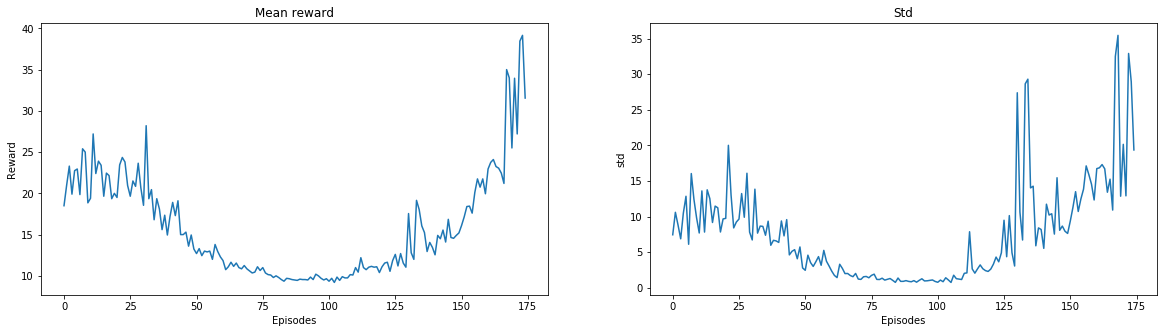

In [68]:
reward_history.plot()

In [ ]:
###### learner.train(100, show_chart)
for i in range(3):
    learner.run()
# display.clear_output(wait=True)

# Lessons Learnt
- Wasted heaps of time forgetting to set s = s_1 after a loop
- Using a MLP (batch 256) with 1 hidden layer of 48 vs 128, the 128 one trained in less than 300 episodes while the 48 gets really wild results
- Using a MLP (batch 256) with 2 hidden layer of 48 will train the network within 500 episodes. Results are somewhat consistent, sometimes it trains even faster than the 128 1 layer MLP. 2 hidden layers of 12 can sometimes still learn in 500 episdoes
- Collecting some data first before training reduces total time required for training. e.g. waiting 1000 steps before training. This is just on observation
- Double Q does seem to have a positive effect on the learning
- Failure reward of -1 didn't seem to make much of a difference. A failure reward of -99 sometimes trains quick, but often wild swings in results
- It seems the magnitude and direction of loss curve doesn't matter much at all, as long as the NN is minimizing the loss as it goes.
- Batch size of 256 vs 64, 256 trains way faster and is much more stable
- F.smooth_l1_loss(Huber Loss) seem to require a higher learning rate 1e-2 and is more unstable. MSE works fine with 1e-3 and is more stable, 1e-2 for MSE trains faster but is less stable

# Mean reward over 100 training sessions
- Deep Q learning
![mean reward](./images/dqn.png)
- Double Q learning
![mean reward](./images/dqn_double.png)


In [ ]:
def process_screen(image):
    img = image[150:330, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def image2state(s1, s0=None):
    img1 = process_screen(s1)
    if s0 is not None:
        img0 = process_screen(s0)
    else:
        img0 = np.zeros_like(img1)
        
    out = np.stack([img1, img0], axis=2)
    out = np.rollaxis(out, 2, 0).astype("float32")
#     out = Variable(torch.from_numpy(out)).float()
    return out


env = gym.make("CartPole-v0")
env.reset()
s0 = env.render(mode='rgb_array')
s1, r, done, _ = env.step(env.action_space.sample())
s1 = env.render(mode='rgb_array')
env.close()

print(screen.shape)
print(process_screen(s0).shape)
print(image2state(s0).shape)
print(image2state(s1, s0).shape)
print(image2state(s1, s0)[0, 0, 0])

In [ ]:


class DQNCNN(nn.Module):
    def __init__(self, *args):
        super(DQNCNN, self).__init__(*args)
        self.conv1 = nn.Conv2d(2, 10, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(10, 15, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(15, 20, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(20, 25, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(25, 30, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(30 * 6 * 19, 600)
        self.fc2 = nn.Linear(600, 100)
        self.fc3 = nn.Linear(100, 20)
        self.fc4 = nn.Linear(20, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
#         print(x.view(x.size(0), -1))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x

dqn = DQNCNN()
dqn.cuda()
print(dqn)
x = image2state(s1, s0)
# x = np.stack([s1, s0], axis=2)
x = np.expand_dims(x, axis=0)
x = Variable(torch.from_numpy(x).cuda()).float()
print(x.cpu().data.numpy().shape)
# print(x)
# x = Variable(torch.randn(2, 2, 180, 600))
        
output = dqn(x)
print(output.cpu().data.numpy().shape)

# create your optimizer
optimizer = optim.SGD(dqn.parameters(), lr=0.01)
criterion = nn.MSELoss()

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = dqn(x)
loss = criterion(output, Variable(torch.Tensor([0,0]).cuda()))
loss.backward()
optimizer.step()    # Does the update

In [ ]:
import copy
class DQNCNNLearner(object):
    def __init__(self, env=None, double_Q=False):
        self.env = env
        self.epsilon = Epsilon(start=1.0, end=0.01, update_increment=0.005)
        self.gamma = 0.99
        self.train_q_per_step = 4
        self.train_q_batch_size = 256
        self.steps_before_training = 1000
        self.target_q_update_frequency = 100
        
        self.memory = ReplayMemory(capacity=10000)
        self.Q = DQNCNN()
        self.Qt = copy.deepcopy(self.Q)# DQNLinear()
        self.Q.cuda()
        self.Qt.cuda()
#         self.Qt.load_state_dict(self.Q.state_dict())
        self.use_double_Q = double_Q
        self.optimizer = optim.Adam(self.Q.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()

        self.reset()
        self.episode_rewards = []
        self.epsilon_log = []
        self.l_tq_squared_error = deque(maxlen=1000)
        

    def get_action(self, s):
        s = self.state_to_tensor(s)
        actions = self.Q(s)
        if np.random.rand() > self.epsilon.value():
            action = np.argmax(actions.cpu().data.numpy())
#             print(actions.data.numpy(), action)
#             print("not exploring", self.epsilon.value())
        else:
            action = self.env.action_space.sample()
#             print("exploring", action, "epsilon:", self.epsilon.value())
        return action

    def state_to_tensor(self, s):
        x = torch.Tensor(s).cuda()
        x = torch.unsqueeze(x, 0)
        x = Variable(x, volatile=True).float()
        return x
    
    def reset(self):
        self.env.reset()
        s0 = self.env.render(mode='rgb_array')
        self.s = self.image2state(s0)
        self.s_image = s0 # need to store this to make it convenient to stack images
        
    def process_screen(self, image):
        img = image[150:330, :]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        return img

    def image2state(self, s1, s0=None):
        img1 = process_screen(s1)
        if s0 is not None:
            img0 = process_screen(s0)
        else:
            img0 = np.zeros_like(img1)

        out = np.stack([img1, img0], axis=2)
        out = np.rollaxis(out, 2, 0).astype("float32")
        return out
    
    def train(self, nb_episodes=1, display=None):
        self.epsilon.isTraining = True
        step = 0
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_action(self.s)
                s_1, r, done, _ = self.env.step(action)
                s_1_image = self.env.render(mode='rgb_array')
                s_1 = self.image2state(s_1_image, self.s_image)
                
                transition = Transition(self.s, action, s_1, r, done)
                self.memory.push(transition)
                episode_reward += r
                step += 1
                self.s = s_1
                self.s_image = s_1_image # need to store this to make it convenient to stack images
                
                if done:
                    break;
                
                if step % self.train_q_per_step == 0 and step > self.steps_before_training:
                    self.train_q()
                    
                if step % self.target_q_update_frequency == 0 and step > self.steps_before_training:
                    self.update_target_q()
                    
            if step > self.steps_before_training:
                self.epsilon.increment() # increment epsilon per episode
#             print("Episode reward: ", episode_reward)
            self.episode_rewards.append(episode_reward)
            self.epsilon_log.append(self.epsilon.value())
            if display is not None and step % 50 == 0:
                display(self)
        if display is not None:
            display(self)
    
    def train_q(self):
#         print("training q. Memory size:", len(self.memory))
        if self.train_q_batch_size >= len(self.memory):
            return
        
        s, a, s_1, r, done = self.memory.sample(self.train_q_batch_size)
        s = Variable(torch.from_numpy(s).cuda()).float()
        a = Variable(torch.from_numpy(a).cuda()).long()
        s_1 = Variable(torch.from_numpy(s_1).cuda(), volatile=True).float()
        r = Variable(torch.from_numpy(r).cuda()).float()
        done = Variable(torch.from_numpy(1 - done).cuda()).float()
        
        # Q_sa = r + gamma * max(Q_s'a')
        Q = self.Q(s)
#         print("s:", s, "Q:", Q)
        Q = Q.gather(1, a)
#         print("a:", a, "Q:", Q)
        Qt = self.Qt(s_1)
#         print("s_1:", s_1, "Qt:", Qt)

        if self.use_double_Q:
            best_action = self.Q(s_1).max(dim=1)[1].view(-1, 1)
            y = r + done * self.gamma * Qt.gather(1, best_action)
        else:
            y = r + done * self.gamma * Qt.max(dim=1)[0].unsqueeze(1)

        y.volatile = False #weird

        loss = self.criterion(Q, y)
#         loss = F.smooth_l1_loss(Q, y)
        self.l_tq_squared_error.append(loss.cpu().data.numpy().sum())
        self.optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
#         for param in self.Q.parameters():
#             param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_q(self):
        """Update the target Q-value function by copying the current Q-value function weights."""
#         self.Qt.load_state_dict(self.Q.state_dict())
        self.Qt = copy.deepcopy(self.Q)
        self.Qt.cuda()

    def run(self):
        self.reset()
        self.epsilon.isTraining = False
#         self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_action(self.s)
            s_1, r, done, _ = self.env.step(action)
            s_1 = self.env.render(mode='rgb_array')
            s_1 = self.image2state(s_1, self.s_image)
            episode_reward += r
            self.s = s_1

            if done:
                break;
        
        self.env.render(close=True)
        print("Total Reward: ", episode_reward)
    
env = gym.make("CartPole-v0")
learner = DQNCNNLearner(env, double_Q=False)

def show_chart(learner):
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(learner.episode_rewards)
    plt.subplot(2, 2, 2)
    plt.xlabel('Last x Training Cycles')
    plt.ylabel('Loss')
    plt.plot(list(learner.l_tq_squared_error))
    plt.subplot(2, 2, 3)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.plot(list(learner.epsilon_log))
    display.clear_output(wait=True)
    display.display(plt.gcf())

%time learner.train(500, show_chart)
# learner.train(4)

env.close()

In [ ]:
#%time learner.train(5000, show_chart) # this lasted like 10 hours just to get to 3400 cus gym needs to render it


In [ ]:
%time learner.train(1, show_chart)
learner.env.close()

In [ ]:
# learner.run()
learner.env.close()